In [50]:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt

import math

#element stiffness matrix
def lk():
    E=1 # ! need to synchronize material properties !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    nu=0.3
    k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
    [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
    [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
    [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
    [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
    [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
    [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
    [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
    return (KE)


# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
    l1=0
    l2=1e9
    move=0.2
    # reshape to perform vector operations
    xnew=np.zeros(nelx*nely)
    while (l2-l1)/(l1+l2)>1e-3:
        lmid=0.5*(l2+l1)
        xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
        
        gt=g+np.sum((dv*(xnew-x)))
        if gt>0 :
            l1=lmid
        else:
            l2=lmid
    return (xnew,gt)

def el_mask_2_nod_mask(el_mask, nelx, nely, ndof):
    node_mask = np.zeros((int(ndof/2), 1))
    for elx in range(nelx):
        for ely in range(nely):
            if el_mask[elx, ely] == 0:
                continue
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely

            node_mask[n1] = 1
            node_mask[n2] = 1
            node_mask[n1 + 1] = 1
            node_mask[n2 + 1] = 1
    
    return node_mask

def gradshape(xi):
    """Gradient of the shape functions for a 4-node, isoparametric element.
        dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
        Input: 1x2,  Output: 2x4"""
    xi,eta = tuple(xi)
    dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
          [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
    return 0.25 * np.array(dN)

class topology_AAGE:
    def __init__(self, nelx, nely, volfrac, penal, rmin, ft):
        print("Minimum compliance problem with OC")
        print("ndes: " + str(nelx) + " x " + str(nely))
        print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
        print("Filter method: " + ["Sensitivity based","Density based"][ft])

        self.penal = penal
        self.rmin = rmin
        self.ft = ft
        self.nelx = nelx
        self.nely = nely
        self.volfrac = volfrac
        self.cell_size = 1
        # Max and min stiffness
        self.Emin=1e-9
        self.Emax=1.0
        # dofs:
        self.ndof = 2*(nelx+1)*(nely+1)
        # Allocate design variables (as array), initialize and allocate sens.
        self.x=self.volfrac * np.ones(nely*nelx,dtype=float)
        self.xold=self.x.copy()
        self.xPhys=self.x.copy()
        self.g=0 # must be initialized to use the NGuyen/Paulino OC approach
        self.dc=np.zeros((nely,nelx), dtype=float)

        # FE: Build the index vectors for the for coo matrix format.
        self.KE=lk()
        self.edofMat=np.zeros((nelx*nely,8),dtype=int)
        self.conn = []
        self.coords = np.zeros((self.ndof,1))

        for elx in range(nelx):
            for ely in range(nely):
                el = ely+elx*nely
                n1=(nely+1)*elx+ely
                n2=(nely+1)*(elx+1)+ely
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])
                self.conn.append([n2, n1, n1 + 1, n2 + 1])

                x_center = self.cell_size/2 + self.cell_size * elx
                y_center = - self.cell_size/2 - self.cell_size * ely

                # x coords
                self.coords[2*n1+2] = x_center - self.cell_size/2
                self.coords[2*n2+2] = x_center + self.cell_size/2
                self.coords[2*n2] = x_center + self.cell_size/2
                self.coords[2*n1] = x_center - self.cell_size/2

                # y coords
                self.coords[2*n1+3] = y_center - self.cell_size/2
                self.coords[2*n2+3] = y_center - self.cell_size/2
                self.coords[2*n2+1] = y_center + self.cell_size/2
                self.coords[2*n1+1] = y_center + self.cell_size/2

        # Construct the index pointers for the coo format
        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten() 

        # Filter: Build (and assemble) the index+data vectors for the coo matrix format
        self.nfilter=int(self.nelx*self.nely*((2*(np.ceil(self.rmin)-1)+1)**2))
        self.iH = np.zeros(self.nfilter)
        self.jH = np.zeros(self.nfilter)
        self.sH = np.zeros(self.nfilter)
        cc=0
        for i in range(self.nelx):
            for j in range(self.nely):
                row=i*self.nely+j
                kk1=int(np.maximum(i-(np.ceil(self.rmin)-1),0))
                kk2=int(np.minimum(i+np.ceil(self.rmin),nelx))
                ll1=int(np.maximum(j-(np.ceil(self.rmin)-1),0))
                ll2=int(np.minimum(j+np.ceil(self.rmin), self.nely))
                for k in range(kk1,kk2):
                    for l in range(ll1,ll2):
                        col=k*self.nely+l
                        fac=self.rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                        self.iH[cc]=row
                        self.jH[cc]=col
                        self.sH[cc]=np.maximum(0.0,fac)
                        cc=cc+1

        # Finalize assembly and convert to csc format
        self.H=coo_matrix((self.sH,(self.iH,self.jH)),shape=(self.nelx*self.nely,self.nelx*self.nely)).tocsc()	
        self.Hs=self.H.sum(1)
        # BC's and support
        self.dofs=np.arange(2*(self.nelx+1)*(self.nely+1))
        self.fixed=np.union1d(self.dofs[0:2*(self.nely+1):2],np.array([2*(self.nelx+1)*(self.nely+1)-1]))
        self.free=np.setdiff1d(self.dofs, self.fixed)
        # Solution and RHS vectors
        self.f=np.zeros((self.ndof,1))
        self.u=np.zeros((self.ndof,1))
        # Set load
        self.f[1,0]=-1

        # Set loop counter and gradient vectors 
        self.loop=0
        self.change=1
        self.dv = np.ones(self.nely*self.nelx)
        self.dc = np.ones(self.nely*self.nelx)
        self.ce = np.ones(self.nely*self.nelx)

        self.obj = 0

        # Set parameters for postprocessing
        
        
        self.coord_disp = np.zeros((self.ndof,1))

        # 2x2 Gauss Quadrature (4 Gauss points)
        # q4 is 4x2
        self.q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)

        ###############################
        # Plane-strain material tangent (see Bathe p. 194)
        # C is 3x3
        E = 100.0
        v = 0.3
        self.C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
    
        # (pre-allocate space for nodal stress and strain)
        node_strain = []
        node_stress = []
        for ni in range(int(self.ndof/2)):              # !!!!!!!!!!!!!!!!!!!!!need to create this in proper way
            node_strain.append([0.0, 0.0, 0.0])
            node_stress.append([0.0, 0.0, 0.0])
        self.node_strain = np.array(node_strain)
        self.node_stress = np.array(node_stress)

        # conn element nodes indeces in node or X_coord_list ([n1, n2, n3, n4])

        # self.emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
        # self.emax = np.array([-9.0e9, -9.0e9, -9.0e9])
        # self.min = np.array([ 9.0e9,  9.0e9,  9.0e9])
        # self.smax = np.array([-9.0e9, -9.0e9, -9.0e9])

        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! add controal max min

        # allocate history variables ## it should be removed for large problems!!!!!!!!!!!!!!!!!
        self.u_hist = []
        self.xPhys_hist = []
        self.itn_hist = []
        self.obj_hist = []

        # !!!!!!!!!!!!!! also add percentage of volume



    def optimization_step(self):

        self.loop=self.loop+1
        # Setup and solve FE problem
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(self.xPhys)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()

        # Remove constrained dofs from matrix
        K = K[self.free,:][:,self.free]

        # Solve system 
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])

        # Objective and sensitivity
        self.ce[:] = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        self.obj=( (self.Emin+self.xPhys**self.penal*(self.Emax-self.Emin))*self.ce ).sum()
        self.dc[:]=(-self.penal*self.xPhys**(self.penal-1)*(self.Emax-self.Emin))*self.ce
        self.dv[:] = np.ones(self.nely*self.nelx)
        
        # Sensitivity filtering:
        if self.ft==0:
            self.dc[:] = np.asarray((self.H*(self.x*self.dc))[np.newaxis].T/self.Hs)[:,0] / np.maximum(0.001,self.x)
        elif self.ft==1:
            self.dc[:] = np.asarray(self.H*(self.dc[np.newaxis].T/self.Hs))[:,0]
            self.dv[:] = np.asarray(self.H*(self.dv[np.newaxis].T/self.Hs))[:,0]
               
        # Optimality criteria
        self.xold[:]=self.x
        (self.x[:], self.g)=oc(self.nelx,self.nely,self.x,self.volfrac,self.dc,self.dv, self.g)
        
        # Filter design variables
        if self.ft==0:   self.xPhys[:]=self.x
        elif self.ft==1:	self.xPhys[:]=np.asarray(self.H*self.x[np.newaxis].T/self.Hs)[:,0]

        # Compute the change by the inf. norm
        self.change=np.linalg.norm(self.x.reshape(self.nelx*self.nely,1)-self.xold.reshape(self.nelx*self.nely,1),np.inf)
        # Plot to screen

        # !!!!!!!!!!!!!!!!!!!!!!!!!! wee needed to calculate mass percenatage

    def optimization(self, n_iter, trsh_chang = 0.01, history_step=5):
        if self.change < trsh_chang: # !!!!!!!!!!!!!!!!! is more accurete to added thrsh by obj or final mass percentage
             print("The result is achieved")
        local_loop = 0
        while self.change>trsh_chang and local_loop<n_iter:
            self.optimization_step()
            # Write iteration history to screen (req. Python 2.6 or newer)
            print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
                        self.loop, self.obj,(self.g+self.volfrac*self.nelx*self.nely)/(self.nelx*self.nely),self.change))
            
            # save history
            if self.loop%history_step == 0 or local_loop == 0:
                self.u_hist.append(self.u.copy())
                self.xPhys_hist.append(self.xPhys.copy())
                self.itn_hist.append(self.loop)
                self.obj_hist.append(self.obj)
                 

            local_loop += 1
             
    def implement_solution(self, new_xPhys):
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!! need to check before
        self.xPhys = new_xPhys

    def estimate_out_solution(self, out_xPhys, return_disp = False):
        ######################### !!!!!!!!!!!!!!!!!!! need to check out_xPhys before
        """
        the function estimates outer xPhys withou implementation of it
        """
        # allocate variables
        ce = np.ones(self.nely*self.nelx)
        u=np.zeros((self.ndof,1))
        # print(out_xPhys.shape)
        # print(self.xPhys.shape)

        # Setup and solve FE problem
        # sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(self.xPhys)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(out_xPhys)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()

        # Remove constrained dofs from matrix
        K = K[self.free,:][:,self.free]

        # Solve system 
        u[self.free,0]=spsolve(K,self.f[self.free,0])

        # Objective and sensitivity
        ce[:] = (np.dot(u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        obj=( (self.Emin+out_xPhys**self.penal*(self.Emax-self.Emin))*ce ).sum()

        if return_disp:
             return obj, u

        else:
             return obj

    def get_obj(self):
        return self.obj

    def get_data_for_NN(self):
        pass

    def get_current_params(self):
        pass

    def postprocess(self, out_xPhys=None, scale=0.01, out_flag = False): # rewrite flag soluton
        # strain in an element: [strain] = B    U
        #                        3x1     = 3x8  8x1
        #
        # strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
        #          = B11 u1          + B13 u1          + B15 u1          + B17 u1
        #          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
        B = np.zeros((3,8))

        if out_flag: # postprocess outer solution
            obj, loc_u = self.estimate_out_solution(out_xPhys, return_disp = True) 
            el_mask = (out_xPhys.reshape((self.nelx, self.nely)) > 0.5)*1                               # !!!!!!!!!!!!!!!!!!!!!!!!!! check if it necessary to revers
              
        
        else:
            loc_u = self.u.copy()
            obj = self.obj
            el_mask = (self.xPhys.copy().reshape((self.nelx, self.nely)) > 0.5)*1

        node_mask = el_mask_2_nod_mask(el_mask, self.nelx, self.nely, self.ndof) 

        for elx in range(self.nelx):
            for ely in range(self.nely):
                el = ely+elx*self.nely
                n1=(self.nely+1)*elx+ely
                n2=(self.nely+1)*(elx+1)+ely

                # cell nodes coords
                nodePts = np.array([[self.coords[2*n1+2], self.coords[2*n1+3]], 
                                    [self.coords[2*n2+2], self.coords[2*n2+3]], 
                                    [self.coords[2*n2], self.coords[2*n2+1]],
                                    [self.coords[2*n1], self.coords[2*n1+1]]]) # it is not necessary in this case, but is needed for non regular mesh
                nodePts = np.squeeze(nodePts, axis=2)

                #stress calculation
                for q in self.q4:
                    dN = gradshape(q)					# 2x4
                    J  = np.dot(dN, nodePts).T			# 2x2
                    dN = np.dot(np.linalg.inv(J), dN)	# 2x4
                    B[0,0::2] = dN[0,:]					# 3x8
                    B[1,1::2] = dN[1,:]
                    B[2,0::2] = dN[1,:]
                    B[2,1::2] = dN[0,:]

                    UU = np.zeros((8,1))				# 8x1 #!!!!!!!!!!mybe reordering is needed
                    UU[4] = loc_u[2*n1+2]   # x
                    UU[5] = loc_u[2*n1+3]   # y
                    UU[6] = loc_u[2*n2+2]   # x
                    UU[7] = loc_u[2*n2+3]   # y
                    UU[0] = loc_u[2*n2]     # x
                    UU[1] = loc_u[2*n2+1]   # y
                    UU[2] = loc_u[2*n1]     # x
                    UU[3] = loc_u[2*n1+1]   # y

                    # get the strain and stress at the integration point
                    strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
                    stress = self.C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
                    
                    # !!!!!!!!!!!!!!!!!! need to select is it global of local
                    self.node_strain[n1 + 1][:] = strain.T[0]    # !!!!!! there is also the reordering maybe is needed
                    self.node_strain[n2 + 1][:] = strain.T[0]
                    self.node_strain[n2][:] = strain.T[0]
                    self.node_strain[n1][:] = strain.T[0]

                    self.node_stress[n1 + 1][:] = stress.T[0]
                    self.node_stress[n2 + 1][:] = stress.T[0]
                    self.node_stress[n2][:] = stress.T[0]
                    self.node_stress[n1][:] = stress.T[0]

        coords_disp = self.coords + loc_u*scale

        x_disp = self.u[::2]
        y_disp = self.u[1::2]

        X_coords = coords_disp[::2] # x - dof in odd indeces
        Y_coords = coords_disp[1::2] # y - dof in even indeces

        disp_module = np.sqrt(x_disp**2 + y_disp**2)
        vM_stress = np.sqrt(self.node_stress[:, 0]**2 + self.node_stress[:, 1]**2 - self.node_stress[:, 1]*self.node_stress[:, 0])
             
        return X_coords, Y_coords, disp_module, vM_stress, obj, node_mask
        
    def postprocess_history(self, out_history=None):

        #!!!!!!!!!!!!!!!!!!!!!!!!! need to add progress bar

        if out_history != None:
            xPhys_hist = out_history[0]
            itn_hist = out_history[1]
            obj_hist = []

        else:
            xPhys_hist = self.xPhys_hist
            itn_hist = self.itn_hist
            obj_hist = self.obj_hist

        # fig, ax = plt.subplots() 
        
        for i in range(len(itn_hist)):
            X_coords, Y_coords, disp_module, vM_stress, obj, node_mask = self.postprocess(out_xPhys=xPhys_hist[i], out_flag=True)

            if out_history != None:
                obj_hist.append(obj)

            # print(node_mask.shape)
            # print(vM_stress.shape)
            # print(self.coords[::2].shape)
            # print(self.coords[1::2].shape)
            
            self.drow_one_step(self.coords[::2], self.coords[1::2], vM_stress, node_mask)
             
        # self.u_hist.append(self.u.copy())
        #         .append(self.xPhys.copy())
        #         self.itn_hist.append(self.loop)
        #         self.obj_hist.append(self.obj)
            
        plt.plot(itn_hist, obj_hist)

    def drow_one_step(self, X_set, Y_set, vM_stress_set, mask):

        bool_mask = (mask > 0)[:, 0]
        plt.scatter(X_set[bool_mask], Y_set[bool_mask], c=vM_stress_set[bool_mask])
        plt.axis('equal')
        plt.show()
        
        
#!!!!!!!!!!!!!!!!!!!!!!!!! need to add time calculation of one iteration      
# Default input parameters
nelx=40
nely=40
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens

test_topo = topology_AAGE(nelx, nely, volfrac, penal, rmin, ft)
test_topo.optimization(50, history_step=2)

Minimum compliance problem with OC
ndes: 40 x 40
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based
it.: 1 , obj.: 304.659 Vol.: 0.400, ch.: 0.200
it.: 2 , obj.: 143.399 Vol.: 0.400, ch.: 0.200
it.: 3 , obj.: 92.569 Vol.: 0.400, ch.: 0.200
it.: 4 , obj.: 68.044 Vol.: 0.400, ch.: 0.200
it.: 5 , obj.: 58.188 Vol.: 0.400, ch.: 0.186
it.: 6 , obj.: 51.285 Vol.: 0.400, ch.: 0.200
it.: 7 , obj.: 46.892 Vol.: 0.400, ch.: 0.196
it.: 8 , obj.: 44.167 Vol.: 0.400, ch.: 0.200
it.: 9 , obj.: 42.545 Vol.: 0.400, ch.: 0.167
it.: 10 , obj.: 41.520 Vol.: 0.400, ch.: 0.150
it.: 11 , obj.: 40.821 Vol.: 0.400, ch.: 0.143
it.: 12 , obj.: 40.300 Vol.: 0.400, ch.: 0.159
it.: 13 , obj.: 39.967 Vol.: 0.400, ch.: 0.130
it.: 14 , obj.: 39.788 Vol.: 0.400, ch.: 0.111
it.: 15 , obj.: 39.654 Vol.: 0.400, ch.: 0.099
it.: 16 , obj.: 39.550 Vol.: 0.400, ch.: 0.082
it.: 17 , obj.: 39.466 Vol.: 0.400, ch.: 0.085
it.: 18 , obj.: 39.384 Vol.: 0.400, ch.: 0.094
it.: 19 , obj.: 39.318 Vol.: 0.400, ch.: 0.111


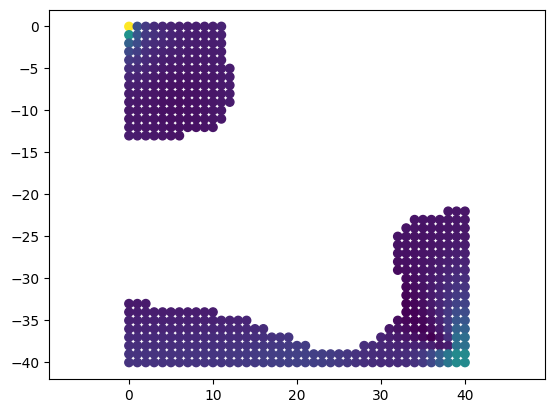

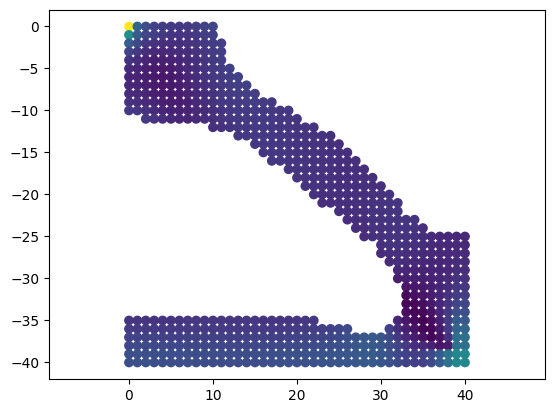

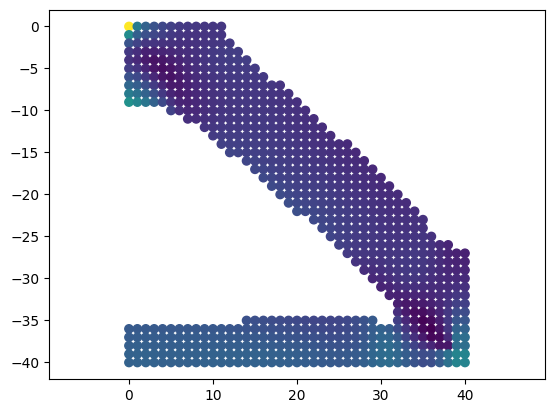

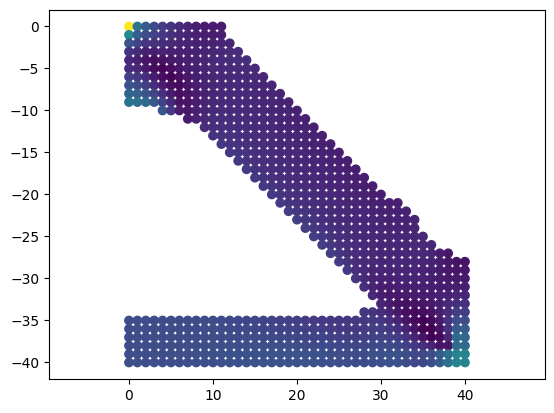

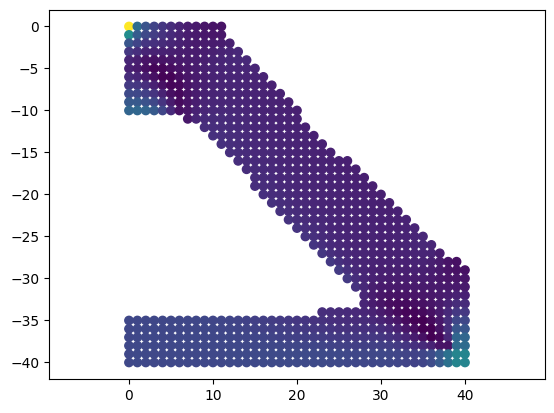

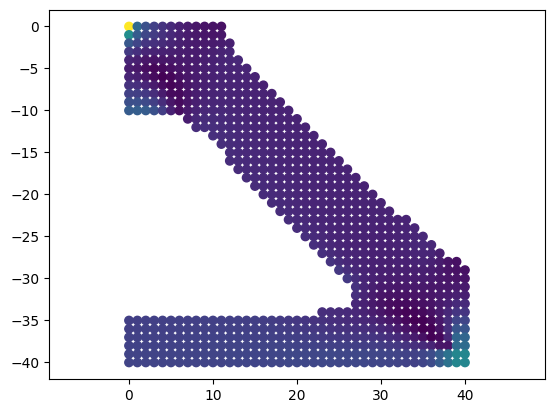

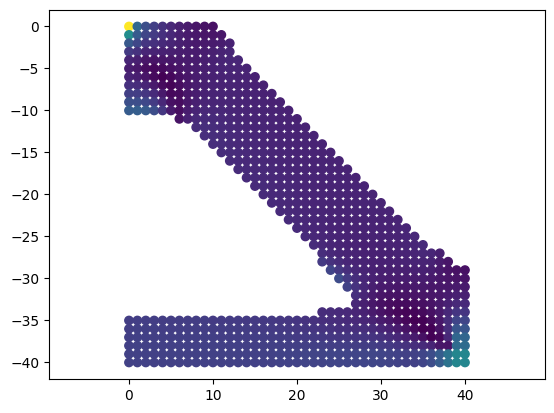

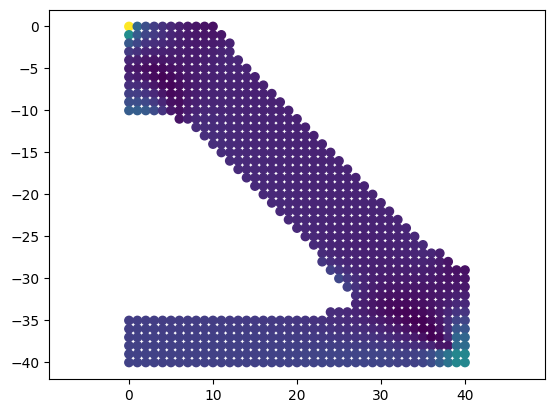

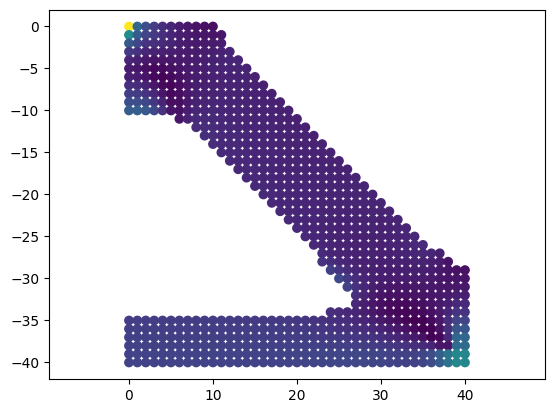

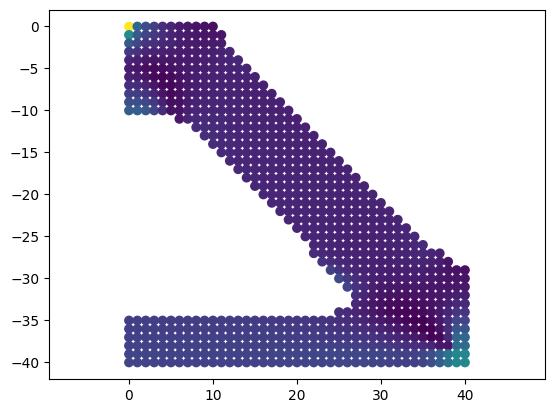

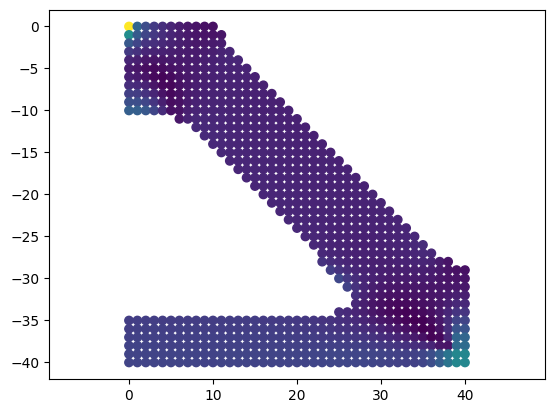

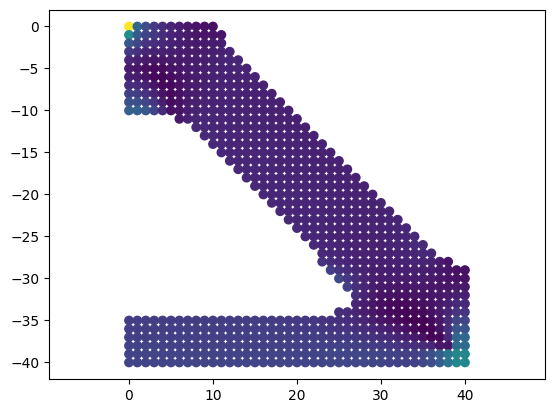

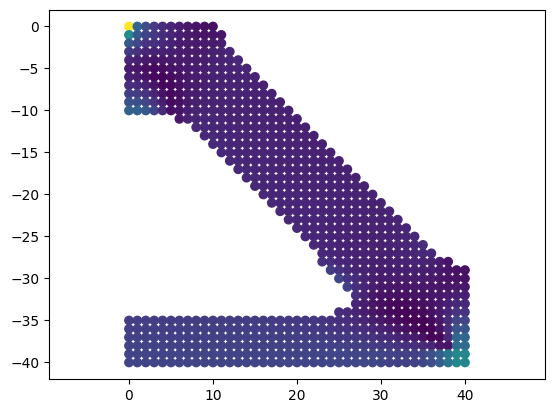

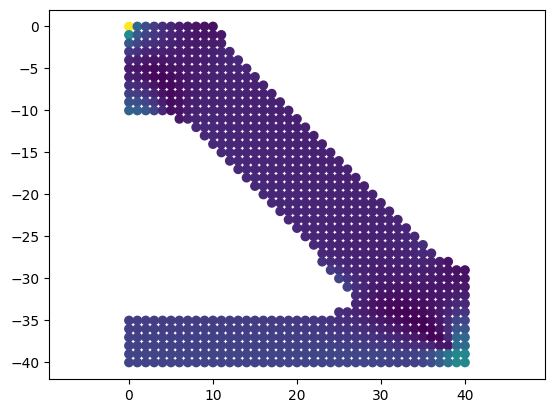

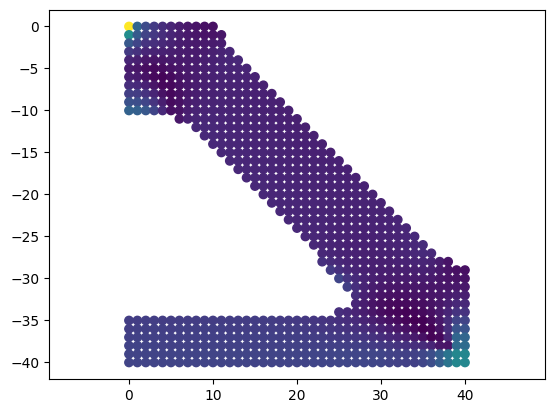

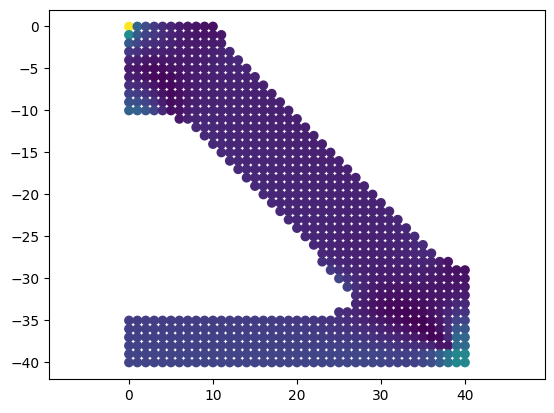

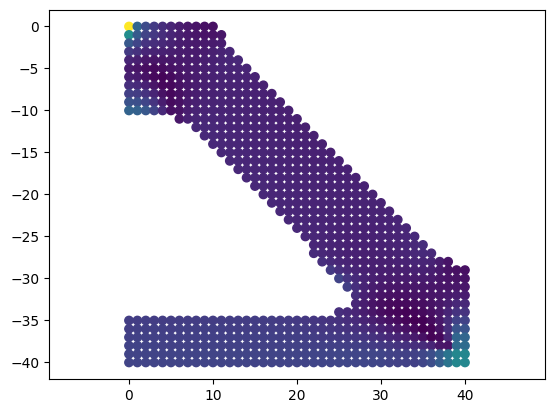

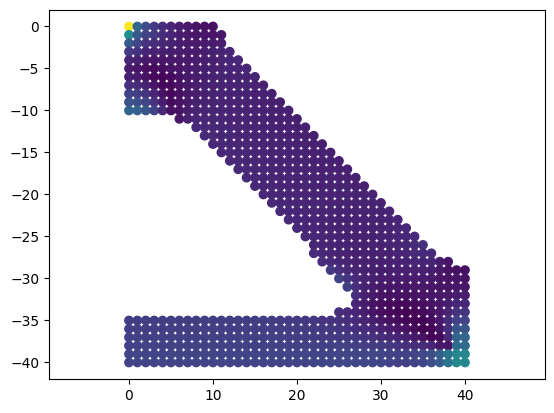

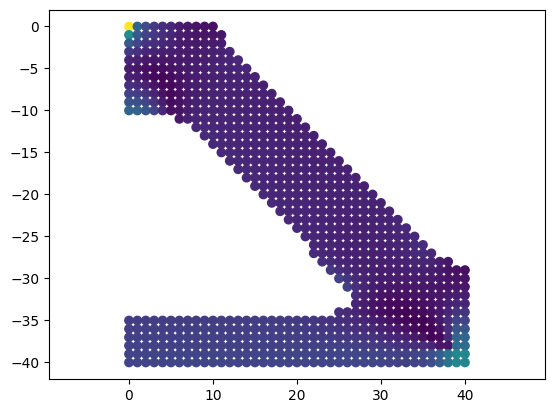

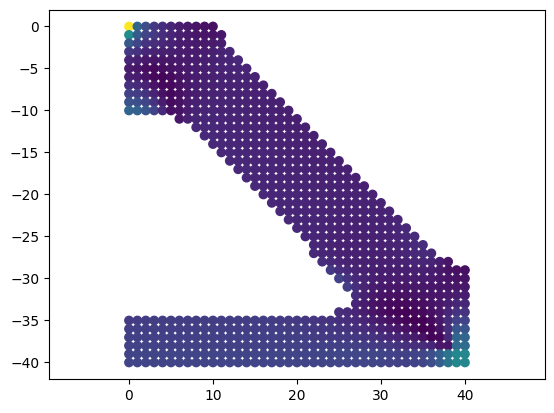

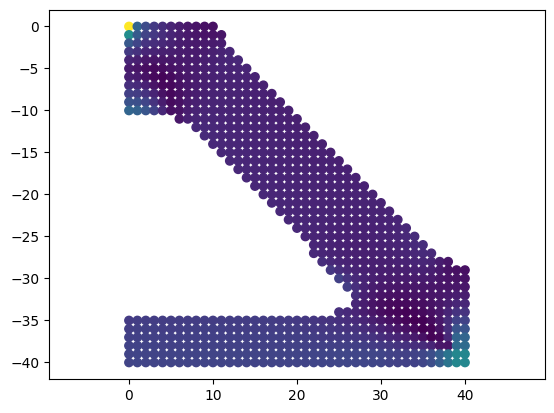

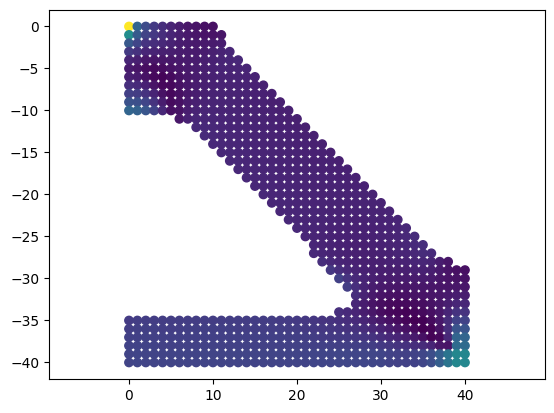

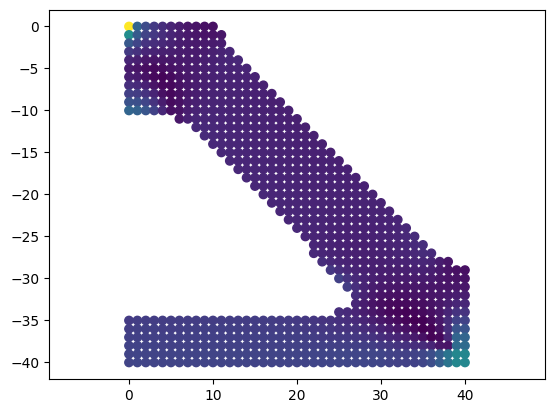

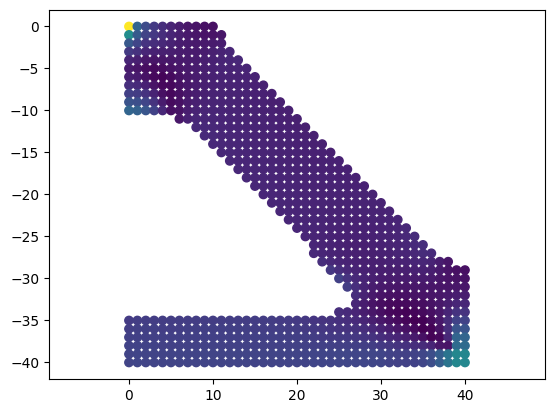

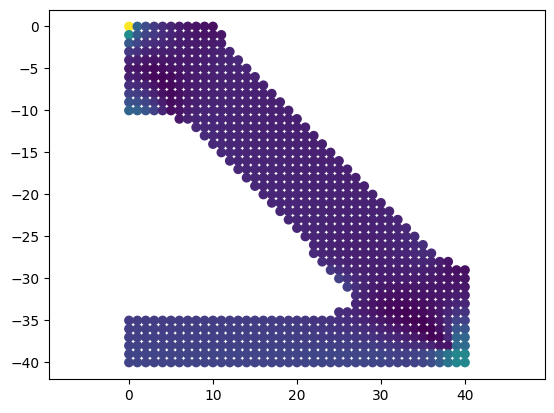

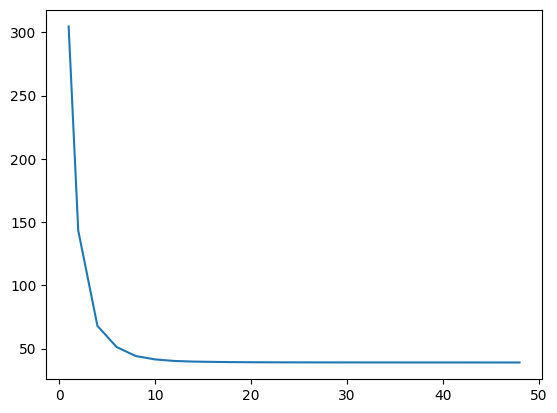

In [51]:
test_topo.postprocess_history()

In [26]:
X_coords, Y_coords, disp_module, vM_stress, obj, node_mask = test_topo.postprocess()

In [30]:
print(X_coords.shape)
print(disp_module.shape)
print(vM_stress.shape)
print(obj)
print(node_mask.shape)

(11041, 1)
(11041, 1)
(11041,)
448.5166366840721
(11041, 1)
